1.0 Data collection

In [ ]:
!pip install kaggle
!pip install pandas
!pip install seaborn
!pip install pansql
!pip install xgboost
!pip install scikit-learn
!pip install -U ydata-profiling --user
!pip install --upgrade ipywidgets

In [50]:
import os
import subprocess
import zipfile
import pandas as pd
import seaborn as sns
color_pallate = sns.color_palette()
import matplotlib.pyplot as plt
import pansql as ps
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
from ydata_profiling import ProfileReport
from sklearn.model_selection import TimeSeriesSplit

In [3]:
PATH  = 'robikscube/hourly-energy-consumption'
DATA = 'Kaggle_DEC'

In [4]:
!kaggle datasets download -d {PATH}

hourly-energy-consumption.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
def download_dataset(path):
    # Run the command and capture the output
    result = subprocess.run(['kaggle', 'datasets', 'download', '-d', path], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    output = result.stdout.decode('utf-8')

    print(output)  # For debugging, to see what the output is

    # Extract the filename from the path
    filename = path.split('/')[-1] + '.zip'
    return filename

path = PATH
zip_file_name = download_dataset(path)
zip_file_name

hourly-energy-consumption.zip: Skipping, found more recently modified local copy (use --force to force download)



'hourly-energy-consumption.zip'

In [6]:
with zipfile.ZipFile(zip_file_name,'r') as zip_ref:
    zip_ref.extractall(DATA)

2.0 Data preprocessing

In [7]:
df = pd.read_csv(DATA + '/PJME_hourly.csv')

In [8]:
df.set_index('Datetime', inplace=True)

In [9]:
print(df.index.dtype)
df.index = pd.to_datetime(df.index)
df.head()

object


,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [10]:
print(df.dtypes)

PJME_MW    float64
dtype: object


In [11]:
df.isnull().sum()

PJME_MW    0
dtype: int64

3.0 EDA

<AxesSubplot: title={'center': 'Energy consumption'}, xlabel='Datetime'>

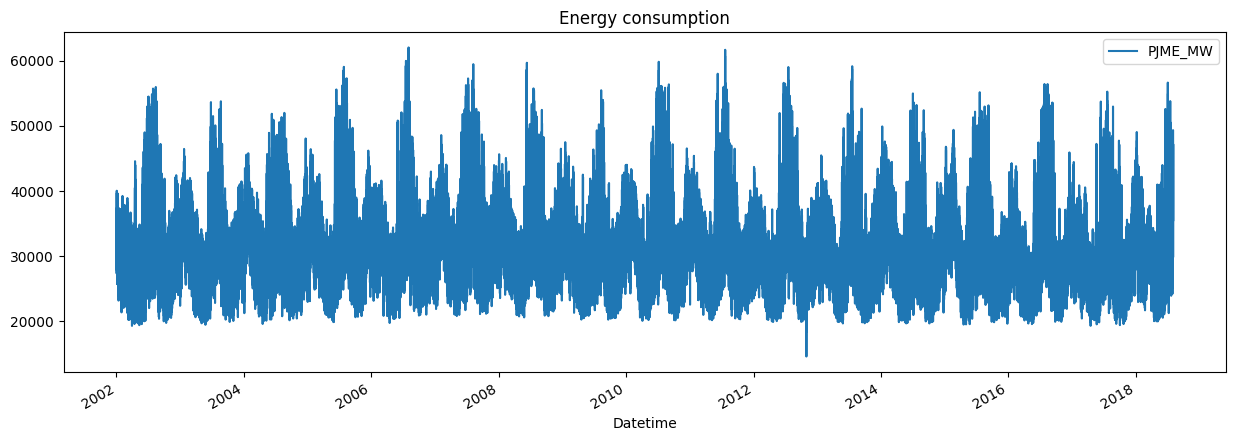

In [12]:
df.plot(figsize=(15, 5), 
        color = color_pallate[0], 
        title='Energy consumption')

In [14]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofweek'] = df.index.dayofweek
    return df


In [20]:
df = create_features(df)

In [17]:
query = '''
SELECT *
FROM test
WHERE dayofweek = 0
AND day <=7
AND year = 2013
AND month = 12
'''

a1 = ps.sqldf(query)
a1.head(1)

,Datetime,PJME_MW,hour,day,month,year,dayofweek
0,2013-12-02 01:00:00.000000,26317.0,1,2,12,2013,0


<AxesSubplot: title={'center': 'sample of energy consumption for a week'}, xlabel='Datetime'>

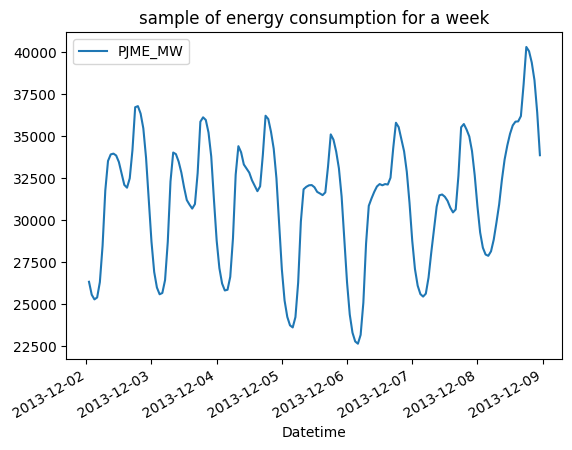

In [18]:
df.loc[(df.index > '2013-12-02') & (df.index < '2013-12-09')].plot(title='sample of energy consumption for a week')

<AxesSubplot: title={'center': 'sample of energy consumption for a day'}, xlabel='Datetime'>

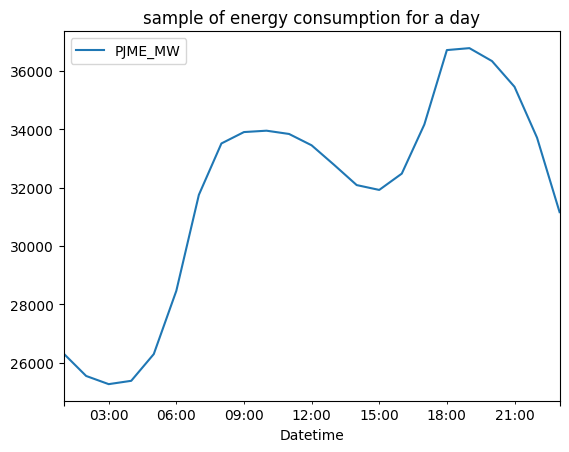

In [19]:
df.loc[(df.index > '2013-12-02') & (df.index < '2013-12-03')].plot(title='sample of energy consumption for a day')

<AxesSubplot: xlabel='hour', ylabel='PJME_MW'>

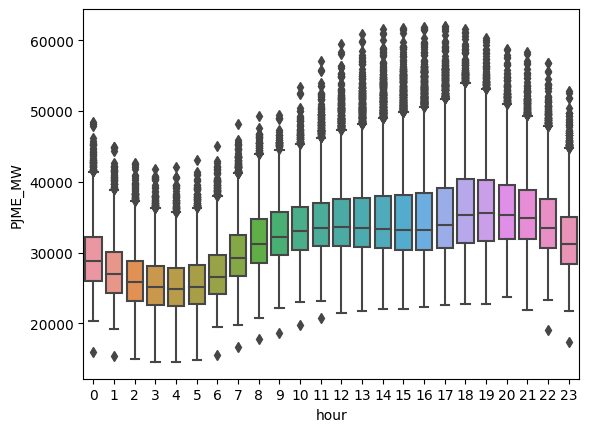

In [21]:
sns.boxplot(data=df, x='hour', y='PJME_MW')

<AxesSubplot: xlabel='dayofweek', ylabel='PJME_MW'>

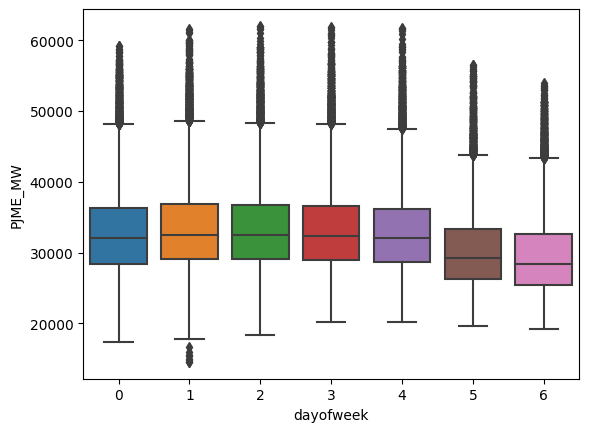

In [22]:
sns.boxplot(data=df, x='dayofweek', y='PJME_MW')

<AxesSubplot: xlabel='month', ylabel='PJME_MW'>

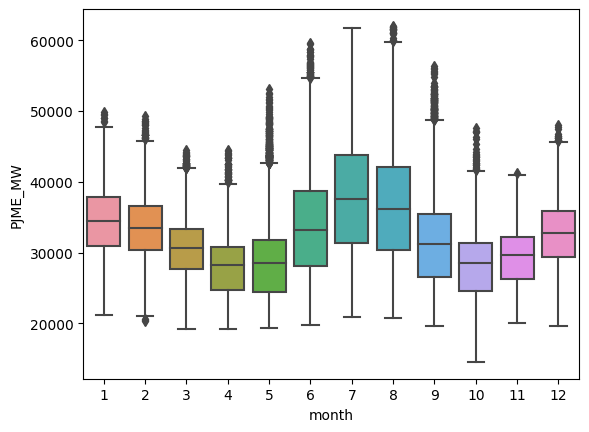

In [23]:
sns.boxplot(data=df, x='month', y='PJME_MW')

<AxesSubplot: title={'center': 'Energy consumption distribution'}, ylabel='Frequency'>

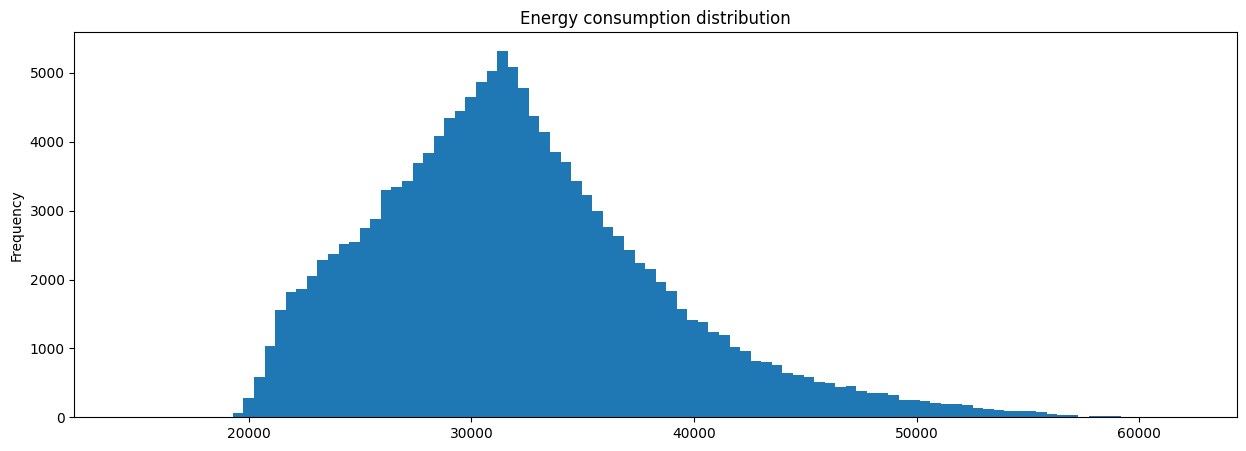

In [24]:
df['PJME_MW'].plot(kind='hist', bins=100, figsize=(15, 5), title='Energy consumption distribution')

In [25]:
profile = ProfileReport(df, title='Pandas Profiling Report')
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot: title={'center': 'extreme outliers'}, xlabel='Datetime'>

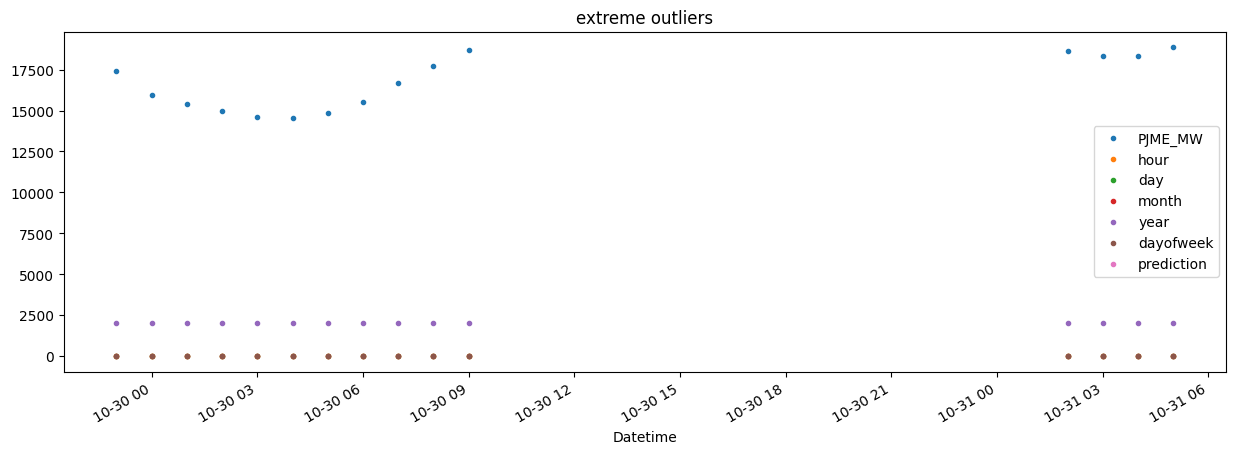

In [49]:
df.query('PJME_MW < 19000').plot(figsize=(15, 5), title='extreme outliers', style='.')

In [51]:
#need to remove extreme outliers that are irregular/unrelated to hours
df = df.query('PJME_MW > 19000').copy()

4.0 Modelling and forecasting 

(just testing manual test/split with xgboost)

(recomended to use time series cross validation such as in 5.0)

Train / Test split

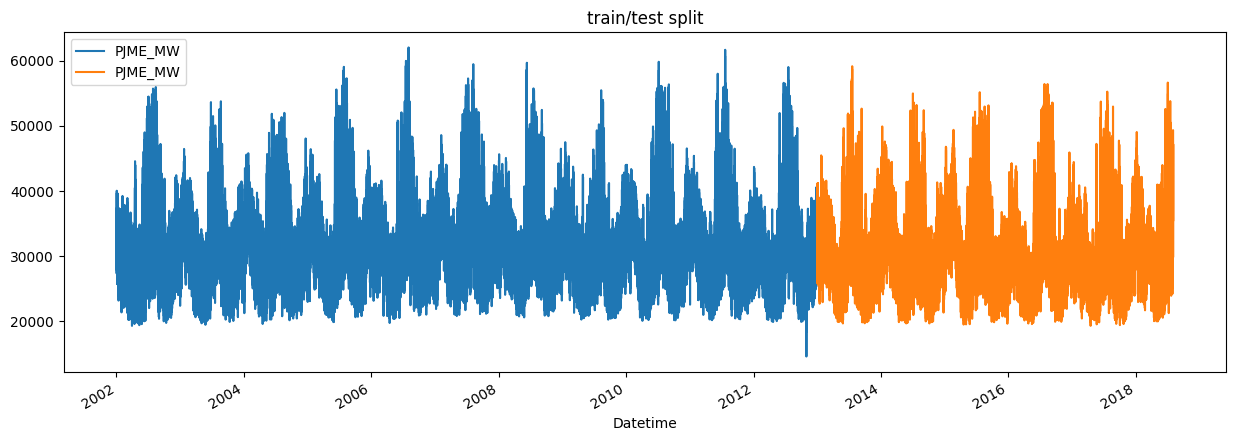

In [13]:
train = df.loc[df.index < '2013-01-01']
test = df.loc[df.index >= '2013-01-01']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, color=color_pallate[0], label='train', title='train/test split')
test.plot(ax=ax, color=color_pallate[1], label='test')
plt.show()

In [15]:
train = create_features(train)
test = create_features(test)

In [16]:
train.head()

,PJME_MW,hour,day,month,year,dayofweek
Datetime,,,,,,
2002-12-31 01:00:00,26498.0,1,31,12,2002,1
2002-12-31 02:00:00,25147.0,2,31,12,2002,1
2002-12-31 03:00:00,24574.0,3,31,12,2002,1
2002-12-31 04:00:00,24393.0,4,31,12,2002,1
2002-12-31 05:00:00,24860.0,5,31,12,2002,1


In [26]:
train.columns

Index(['PJME_MW', 'hour', 'day', 'month', 'year', 'dayofweek'], dtype='object')

In [27]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'day', 'month', 'year', 'dayofweek']
TARGET = 'PJME_MW'

In [28]:
x_train = train[FEATURES]
y_train = train[TARGET]

x_test = test[FEATURES]
y_test = test[TARGET]

Modelling

In [29]:
xg = xgb.XGBRegressor(n_estimators=1000,
                      max_depth=6,
                      learning_rate=0.005,
                      subsample=1,
                      random_state=5,
                      early_stopping_rounds=50,
                      )
xg.fit(x_train, y_train,
       eval_set=[(x_train, y_train), (x_test, y_test)],
       verbose=100)

[0]	validation_0-rmse:32894.04035	validation_1-rmse:31896.73666
[100]	validation_0-rmse:20129.55592	validation_1-rmse:19237.25329
[200]	validation_0-rmse:12493.61860	validation_1-rmse:11743.60632
[300]	validation_0-rmse:8014.21003	validation_1-rmse:7477.31243
[400]	validation_0-rmse:5487.98518	validation_1-rmse:5231.20740
[500]	validation_0-rmse:4149.74658	validation_1-rmse:4248.73446
[600]	validation_0-rmse:3499.48528	validation_1-rmse:3874.07106
[700]	validation_0-rmse:3183.84364	validation_1-rmse:3733.56549
[800]	validation_0-rmse:2989.02176	validation_1-rmse:3689.15444
[876]	validation_0-rmse:2903.26965	validation_1-rmse:3689.24410


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=5, ...)

In [30]:
xg.feature_importances_

array([0.5812306 , 0.02521226, 0.16640098, 0.0241666 , 0.20298962],
      dtype=float32)

<AxesSubplot: title={'center': 'Feature Importance'}>

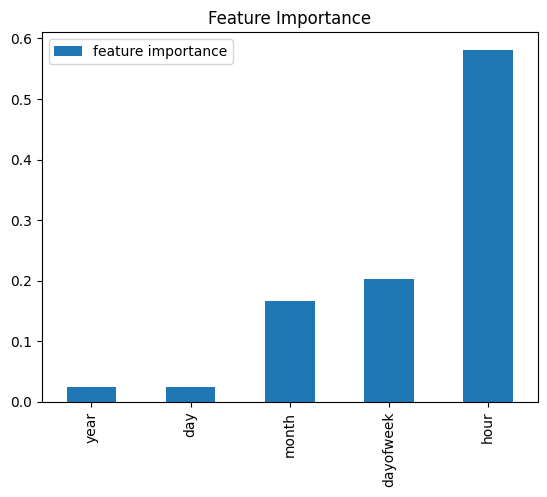

In [31]:
fi = pd.DataFrame(data=xg.feature_importances_, 
             index=xg.feature_names_in_, 
             columns=['feature importance'],)
fi.sort_values('feature importance').plot(kind='bar', title='Feature Importance')

Forecasting

In [32]:
test['prediction'] = xg.predict(x_test)

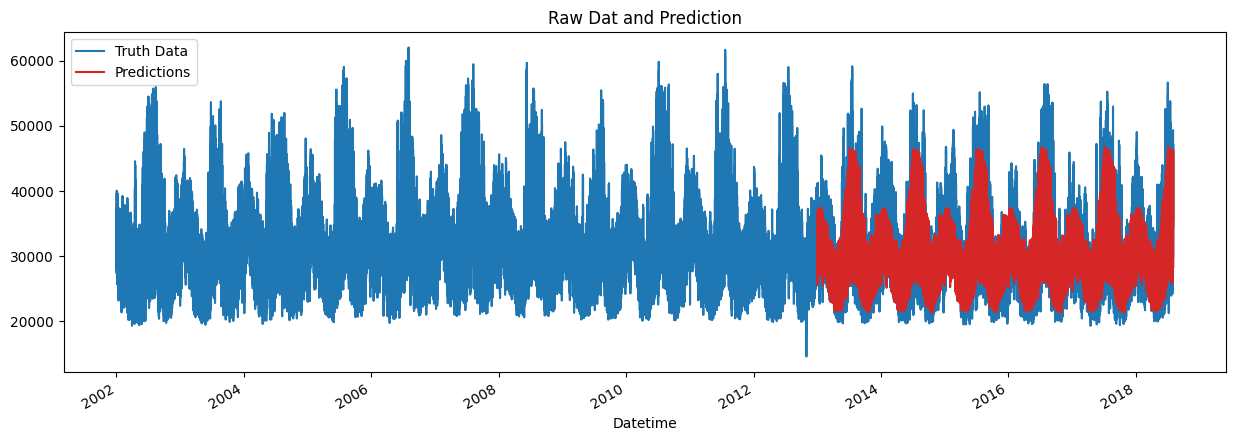

In [33]:
df = df.merge(test[['prediction']], how='left',
            left_index=True, 
            right_index=True)

ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, color=color_pallate[3])
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction' )
plt.show()

In [34]:
query = '''
SELECT *
FROM test
WHERE dayofweek = 0
AND day <=7
AND year = 2017
AND month = 12
'''

a1 = ps.sqldf(query)
a1.head(1)

,Datetime,PJME_MW,hour,day,month,year,dayofweek,prediction
0,2017-12-04 01:00:00.000000,26472.0,1,4,12,2017,0,25782.763672


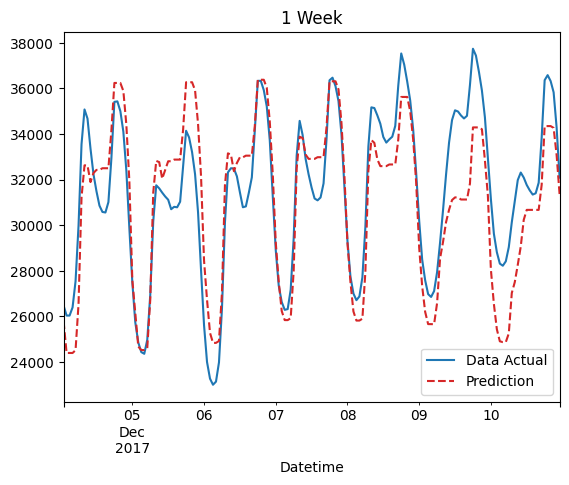

In [35]:
ax = df.loc[(df.index > '2017-12-04') & (df.index < '2017-12-11')]['PJME_MW']\
    .plot()
df.loc[(df.index > '2017-12-04') & (df.index < '2017-12-11')]['prediction']\
    .plot(ax=ax, color=color_pallate[3], style='--')
plt.legend(['Data Actual', 'Prediction'])
ax.set_title('1 Week')
plt.show()

In [36]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(score)

3686.1830786134365


### 5.0 Time series cross validation

In [ ]:
df = df.drop('prediction', axis = 1)

In [57]:
df.head()

,PJME_MW,hour,day,month,year,dayofweek
Datetime,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,2002,1
2002-01-01 02:00:00,29265.0,2,1,1,2002,1
2002-01-01 03:00:00,28357.0,3,1,1,2002,1
2002-01-01 04:00:00,27899.0,4,1,1,2002,1
2002-01-01 05:00:00,28057.0,5,1,1,2002,1


In [58]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*2, gap=24)
df = df.sort_index()